Hello this is Jensen's branch

In [9]:
!pip install numpy matplotlib scipy networkx ndlib pandas

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [11]:
rng = rng = np.random.default_rng(seed=42)

In [12]:
import numpy as np

def gillespie(initial, beta, gamma, mu, max_time, rng):
    S, I, R = initial

    # initialize
    SIR_states = [[S, I, R]]
    timestamps = [0.0]

    events = np.array([
        [ 1,  0,  0],   # Birth
        [-1, +1,  0],   # Infection
        [ 0, -1, +1],   # Recovery
        [-1,  0,  0],   # Death S
        [ 0, -1,  0],   # Death I
        [ 0,  0, -1]    # Death R
    ])

    while timestamps[-1] < max_time and (S+I+R) > 0:
        N = S + I + R

        event_rates = np.array([
            mu * N,
            beta * S*I/N if N > 0 else 0,
            gamma * I,
            mu * S,
            mu * I,
            mu * R
        ])

        # Draw random uniforms for each event
        U = rng.random(len(event_rates))

        # Compute waiting times (τ_i = -log(U_i)/rate_i)
        dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)

        dt_min = np.min(dt_list)
        event = np.argmin(dt_list)

        if dt_min == np.inf:
            break

        # Update time
        timestamps.append(timestamps[-1] + dt_min)

        # Update state
        dS, dI, dR = events[event]
        S, I, R = max(0, S+dS), max(0, I+dI), max(0, R+dR)

        SIR_states.append([S,I,R])

    return np.array(timestamps), np.array(SIR_states)


In [13]:
def SIR_demography(y, t, N, beta, gamma, mu):
    '''SIR model with demography'''
    
    dSdt = mu - beta*y[0]*y[1] - mu*y[0]
    dIdt = beta*y[0]*y[1] - gamma*y[1] - mu*y[1]
    dRdt = gamma*y[1] - mu*y[2]
    
    return [dSdt, dIdt, dRdt]

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


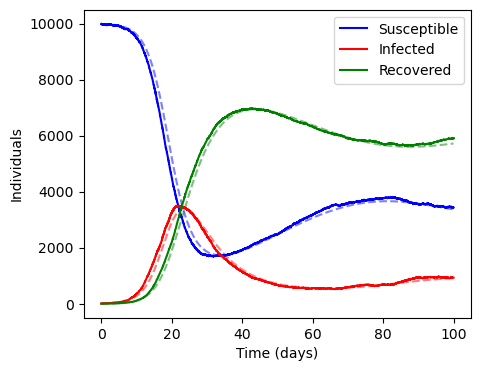

In [14]:
# Define population parameters
N = 10000
I0 = 10

# Define model parameters
beta = 1/2
gamma = 1/7
mu = 0.02

# Duration of simulation
days = 100

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]
event_rates = [mu, beta, gamma, mu, mu, mu]

# Run gillepsie algorithm
time, values = gillespie(initial, beta, gamma, mu, 100, rng)

# Gather values over time for each compartment
susceptible = [event[0] for event in values]
infected = [event[1] for event in values]
recovered = [event[2] for event in values]

# Inital parameters deterministic model
y0 = [(N-I0)/N, I0/N, 0]

# Determine timesteps and resolution
t = np.linspace(0, days, 1001)

# Get deteministic solution
solution = odeint(SIR_demography, y0, t, args=(N, beta, gamma, mu))

# Plot data
fig = plt.figure(figsize=(5,4))

# Plot deteministic model
plt.plot(t, solution[:,0] * 10000,'b--', alpha=0.5)
plt.plot(t, solution[:,1] * 10000,'r--', alpha=0.5)
plt.plot(t, solution[:,2] * 10000,'g--', alpha=0.5)

# Plot gillepsie model
plt.plot(time, susceptible, 'b-', label=r'Susceptible')
plt.plot(time, infected, 'r-', label=r'Infected')
plt.plot(time, recovered, 'g-', label=r'Recovered')

plt.ylabel('Individuals')
plt.xlabel('Time (days)')
plt.legend(loc='best')
plt.show()

In [15]:
def gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng):
    # initialize lists 
    all_S, all_I =  [], []
    initial = [N-I0, I0, 0]
    y0 = [(N-I0)/N, I0/N, 0]
    
    interpolation_grid = np.linspace(0, max_time, 1000)
    results = []

    for gamma in gammas:
        for beta in betas:
            run_S, run_I = [], []

            for _ in range(n_runs):
                t, SIR = gillespie(initial, beta, gamma, mu, max_time, rng)
                S, I, R = SIR.T

                # Interpolate to common time grid
                S_interp = np.interp(interpolation_grid, t, S)
                I_interp = np.interp(interpolation_grid, t, I)

                run_S.append(S_interp)
                run_I.append(I_interp)
    
            # stochastic solutions
            all_S = np.array(run_S)
            all_I = np.array(run_I)

            # deterministic solutions
            solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu))
            S_d, I_d, R = solution.T
            results.append((beta, gamma, all_S, all_I, S_d, I_d))
    
    return results, interpolation_grid
              

In [16]:
def compute_statistics(all_S, all_I):
    all_S, all_I = np.array(all_S), np.array(all_I)
    I_mean = all_I.mean(axis=0)
    S_mean = all_S.mean(axis=0)
    I_var = all_I.var(axis=0)
    cov_value = np.cov(S_mean, I_mean)[0, 1]
    return I_mean, S_mean, I_var, cov_value

## Intuition ##
As $R0$ grows, the negative covariance between $I(t)$ and $S(t)$ shrinks due to different parametrical settings of $\beta$ and $\gamma$,

### stochastic resonance ###


In [17]:
def plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs):
    I_mean, S_mean, I_var, cov_SI = compute_statistics(all_S, all_I)

    plt.figure(figsize=(10, 5))
    for S in all_S:
        plt.plot(interpolation_grid, S, color='black', alpha=0.2)
    for I_run in all_I:
        plt.plot(interpolation_grid, I_run, color='gray', alpha=0.2)

    plt.plot(interpolation_grid, I_mean, color='red', lw=2, label='Mean I(t)')
    plt.fill_between(interpolation_grid,
                     I_mean - np.sqrt(I_var),
                     I_mean + np.sqrt(I_var),
                     color='tab:orange', alpha=0.3, label='±1 Std Dev')
    plt.plot(interpolation_grid, S_mean, color='blue', lw=2, label='Mean S(t)')

    plt.plot(interpolation_grid, S_d * N, 'b--', lw=2, label='S(t) deterministic')
    plt.plot(interpolation_grid, I_d * N, 'r--', lw=2, label='I(t) deterministic')

    plt.xlabel("Time")
    plt.ylabel("Individuals")
    plt.title(f"Stochastic Gillespie (β={beta}, γ={gamma}, runs={n_runs})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    print(f"β={beta}, γ={gamma}: Cov(S,I) = {cov_value:.4f}")


In [18]:
rng = np.random.default_rng(42)
I0 = 10
N = 1000
betas = np.linspace(0.1, 2.0, 10)   # from 0.1 to 2.0 inclusive
gammas = np.linspace(0.1, 0.5, 10)  # from 0.1 to 0.5 inclusive
mu = 1/40
n_runs = 10
max_time = 50

results, interpolation_grid = gillespie_runs(I0, N, betas, gammas, mu, n_runs, max_time, rng)

# for beta, gamma, all_S, all_I, S_d, I_d in results:
#     plot_results(beta, gamma, interpolation_grid, all_S, all_I, S_d, I_d, N, n_runs)


/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


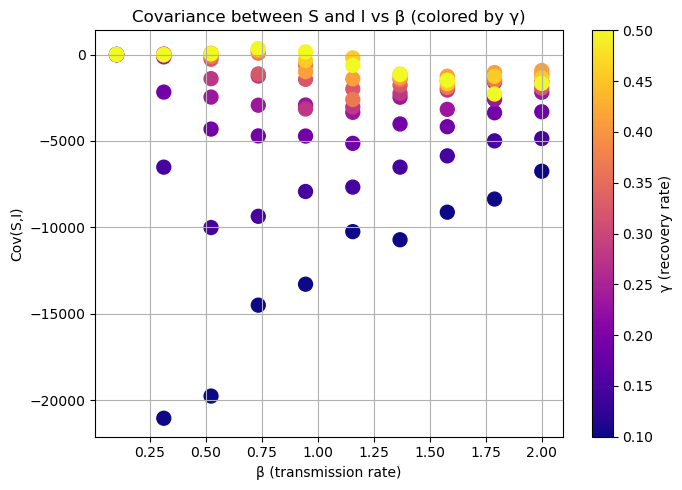

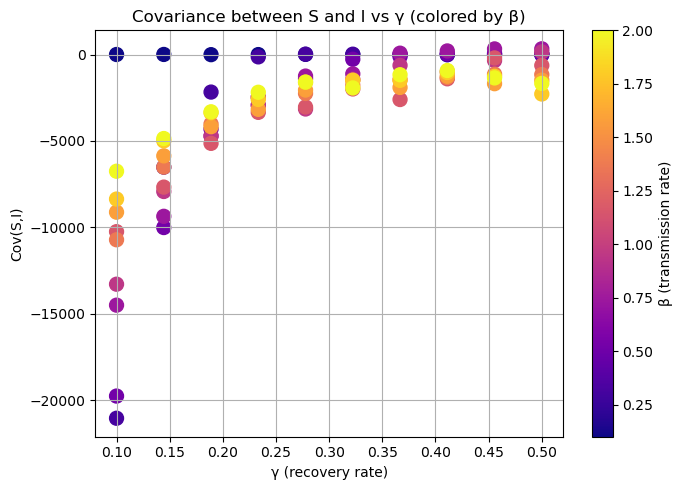

In [19]:
# make pandas dataframe of the data
cov_data = []
for beta, gamma, all_S, all_I, S_d, I_d in results:
    I_mean, S_mean, I_var, cov_value = compute_statistics(all_S, all_I)
    R0 = beta / gamma
    cov_data.append((beta, gamma, R0, cov_value, I_var))

cov_df = pd.DataFrame(cov_data, columns=["β", "γ", "R₀", "Cov(S,I)", "Var(I)"])
cov_df = cov_df.sort_values(by=["γ", "β"]).reset_index(drop=True)


# Covariance
plt.figure(figsize=(7, 5))
sc = plt.scatter(cov_df["β"], cov_df["Cov(S,I)"],
                 c=cov_df["γ"], cmap="plasma", s=100)
plt.colorbar(sc, label="γ (recovery rate)")
plt.xlabel("β (transmission rate)")
plt.ylabel("Cov(S,I)")
plt.title("Covariance between S and I vs β (colored by γ)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sc = plt.scatter(cov_df["γ"], cov_df["Cov(S,I)"],
                 c=cov_df["β"], cmap="plasma", s=100)
plt.colorbar(sc, label="β (transmission rate)")
plt.xlabel("γ (recovery rate)")
plt.ylabel("Cov(S,I)")
plt.title("Covariance between S and I vs γ (colored by β)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Stochastic resonance functions ##
The functions for varying variables among N, mu, beta, gamma

In [20]:
def stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for N_val in N_values:
        initial = [N_val - I0, I0, 0]
        y0 = [(N_val - I0) / N_val, I0 / N_val, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N_val, beta, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((N_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [21]:
def stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for beta_val in beta_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta_val, gamma, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta_val, gamma, mu))
        S_d, I_d, R_d = solution.T

        results.append((beta_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [22]:
def stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for gamma_val in gamma_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma_val, mu, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma_val, mu))
        S_d, I_d, R_d = solution.T

        results.append((gamma_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [23]:
def stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng):
    interpolation_grid = np.linspace(0, t_max, 1000)
    results = []

    for mu_val in mu_values:
        initial = [N - I0, I0, 0]
        y0 = [(N - I0) / N, I0 / N, 0]

        run_S, run_I = [], []

        for _ in range(n_runs):
            t, SIR = gillespie(initial, beta, gamma, mu_val, t_max, rng)
            S, I, R = SIR.T
            S_interp = np.interp(interpolation_grid, t, S)
            I_interp = np.interp(interpolation_grid, t, I)
            run_S.append(S_interp)
            run_I.append(I_interp)

        all_S = np.array(run_S)
        all_I = np.array(run_I)

        solution = odeint(SIR_demography, y0, interpolation_grid, args=(N, beta, gamma, mu_val))
        S_d, I_d, R_d = solution.T

        results.append((mu_val, all_S, all_I, S_d, I_d))

    return results, interpolation_grid

In [24]:
def compute_I_statistics(all_I, interpolation_grid, N_val, beta_val, gamma_val, mu_val):
    """
    Compute mean, std, normalized std, equilibrium, and transient integrals.
    """
    I_mean = all_I.mean(axis=0)
    I_std = all_I.std(axis=0)

    # --- Normalized std (resonance strength) ---
    total_std = np.sqrt(np.mean(I_std**2))
    mean_I_overall = np.mean(I_mean)
    normalized_std = total_std / mean_I_overall if mean_I_overall > 0 else np.nan

    # --- Deterministic equilibrium ---
    R0 = beta_val / (gamma_val + mu_val)
    I_star = mu_val * (R0 - 1) * N_val / beta_val if R0 > 1 else 0

    dt = interpolation_grid[1] - interpolation_grid[0]
    
    transient_integrals_rel = [
        np.trapz(np.abs(I - I_star), dx=dt) /
        ((I_star if I_star > 0 else np.mean(I)) *  N_val)
        for I in all_I
    ]
    mean_transient_rel = np.mean(transient_integrals_rel)

    return I_mean, I_std, normalized_std, I_star, mean_transient_rel

In [25]:
def plot_stochastic_resonance(results, interpolation_grid, base_N, base_beta, base_gamma, base_mu, vary):
    """
    Plot one figure per parameter value. Show stochastic vs deterministic curves,
    equilibrium line, and annotate σ/mean + transient integrals.
    """
    all_results = []

    for value, all_S, all_I, S_d, I_d in results:
        # --- Assign parameters for this run ---
        if vary == 'N':
            N_val, beta_val, gamma_val, mu_val = value, base_beta, base_gamma, base_mu
        elif vary == 'beta':
            N_val, beta_val, gamma_val, mu_val = base_N, value, base_gamma, base_mu
        elif vary == 'gamma':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, value, base_mu
        elif vary == 'mu':
            N_val, beta_val, gamma_val, mu_val = base_N, base_beta, base_gamma, value
        else:
            raise ValueError("Parameter 'vary' must be one of: 'N', 'beta', 'gamma', 'mu'")

        # statistics computed
        I_mean, I_std, normalized_std, I_star, mean_tr_rel = \
            compute_I_statistics(all_I, interpolation_grid, N_val, beta_val, gamma_val, mu_val)

        # plot results
        plt.figure(figsize=(8, 4))
        plt.plot(interpolation_grid, I_mean, 'r', lw=2, label='Mean stochastic I(t)')
        plt.fill_between(interpolation_grid, I_mean - I_std, I_mean + I_std,
                         color='orange', alpha=0.3, label='±1 std')
        plt.plot(interpolation_grid, I_d * N_val, 'b--', lw=2, label='Deterministic I(t)')
        plt.axhline(I_star, color='k', ls='--', lw=1.2, label=f'I* = {I_star:.1f}')
        plt.title(f"Varying {vary} = {value} | N={N_val}, β={beta_val}, γ={gamma_val}, μ={mu_val:.4f}")
        plt.xlabel("Time")
        plt.ylabel("Infected individuals")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Store summary
        all_results.append((value, normalized_std, mean_tr_rel))

    return all_results

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)
/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_4695/2693918605.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(I - I_star), dx=dt) /


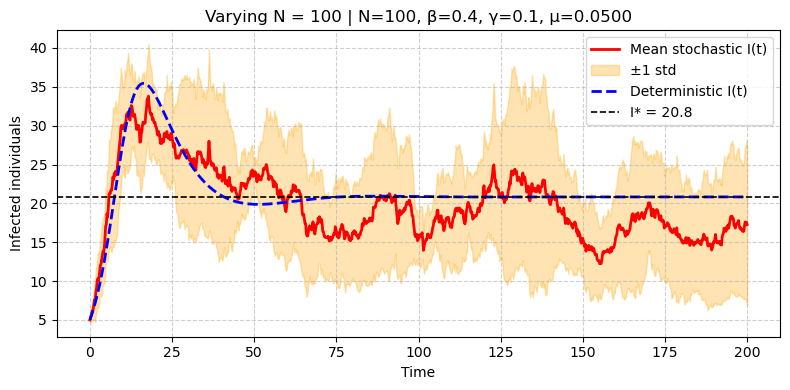

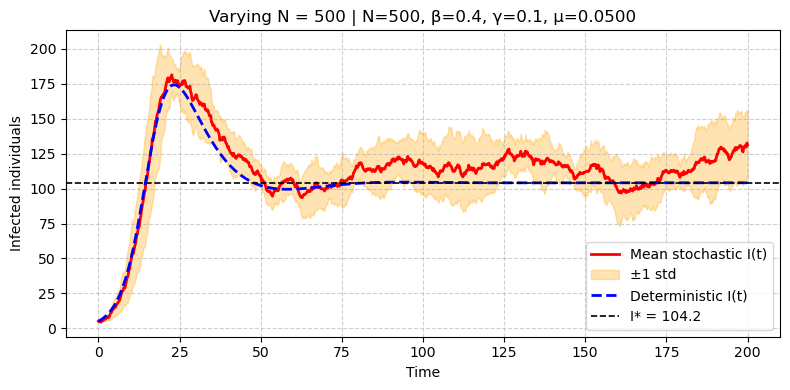

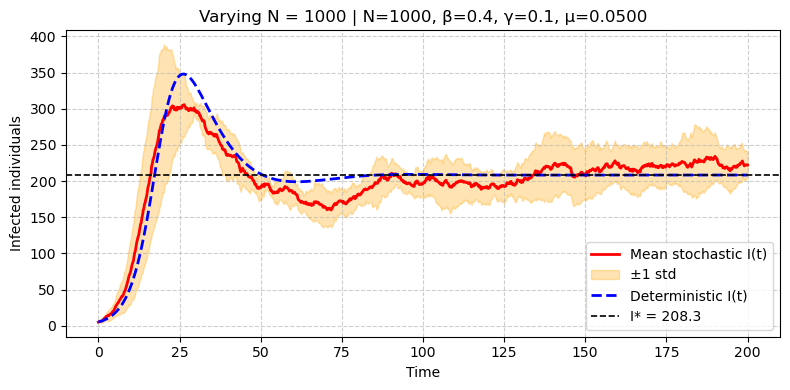

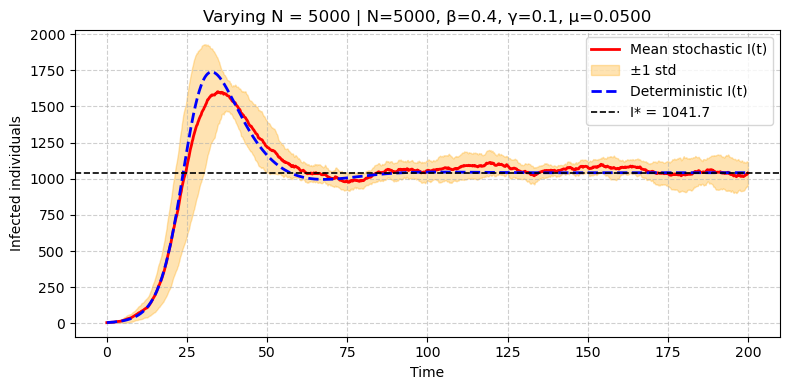

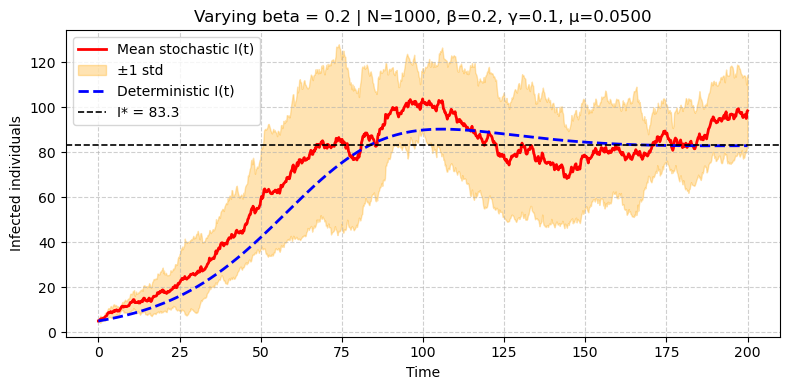

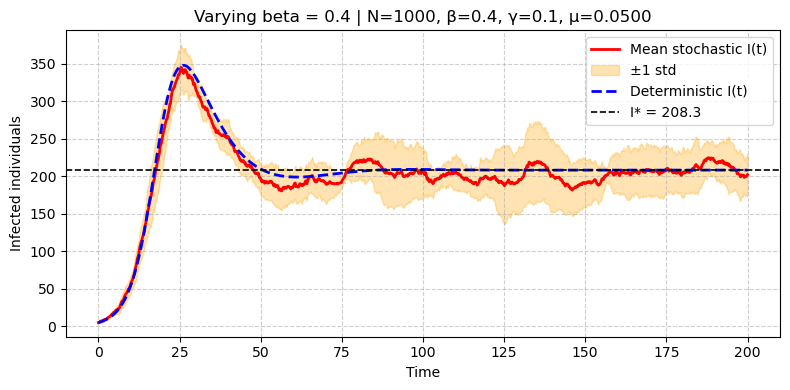

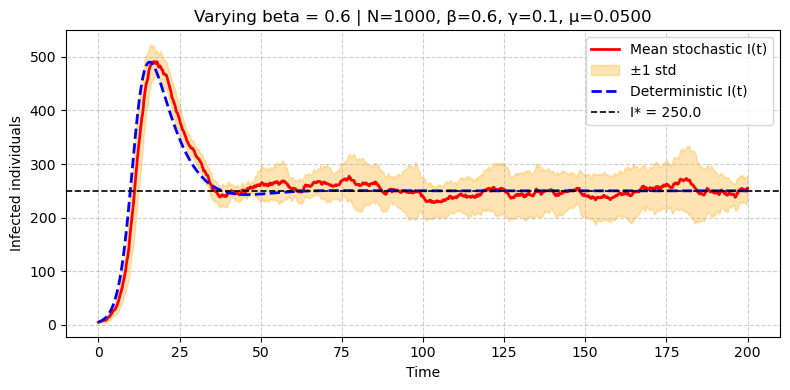

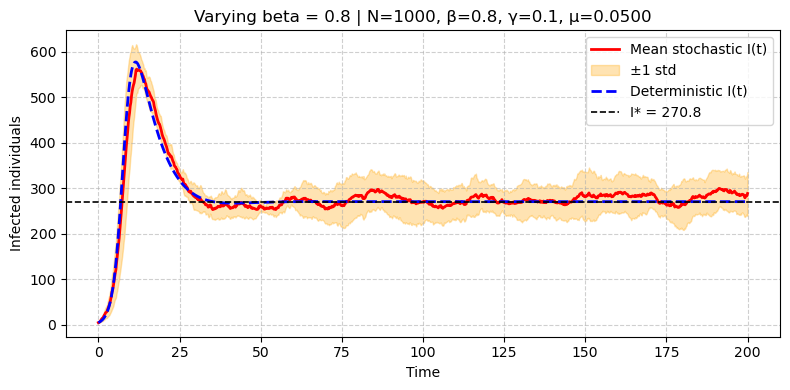

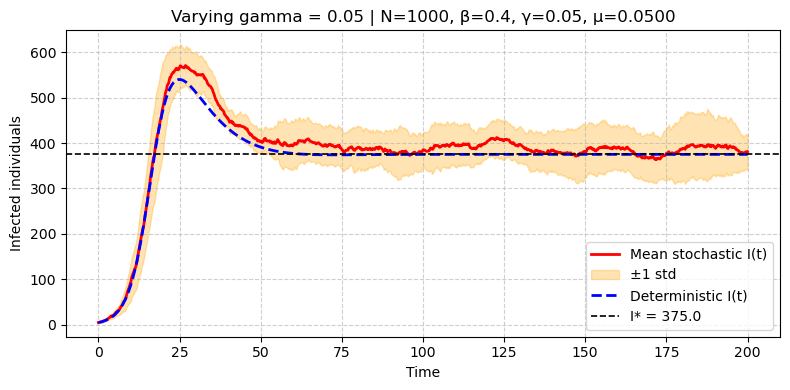

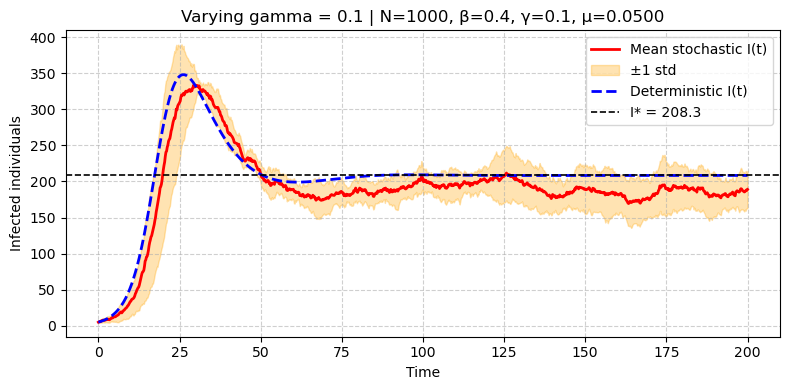

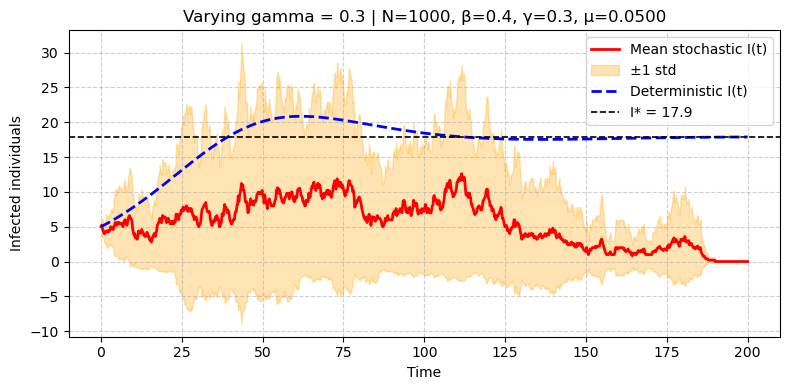

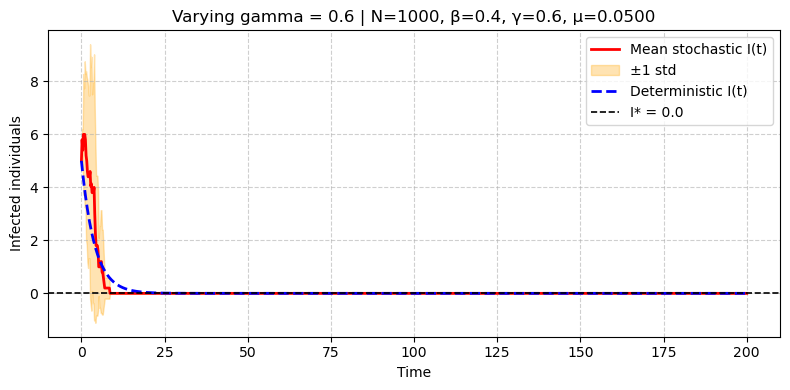

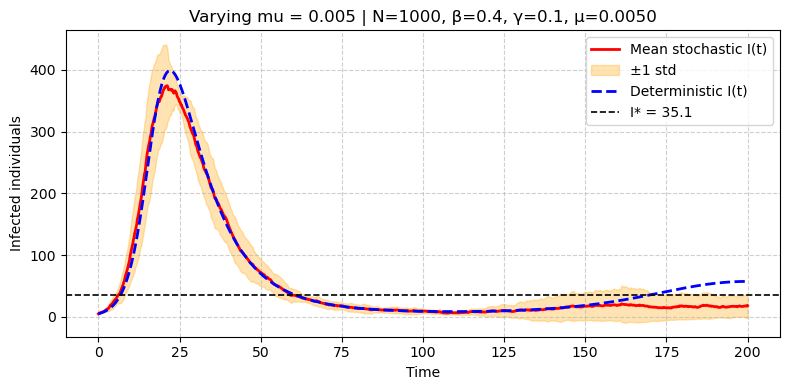

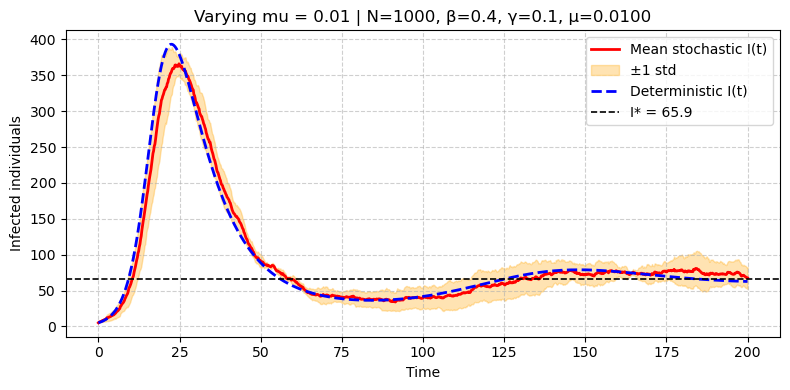

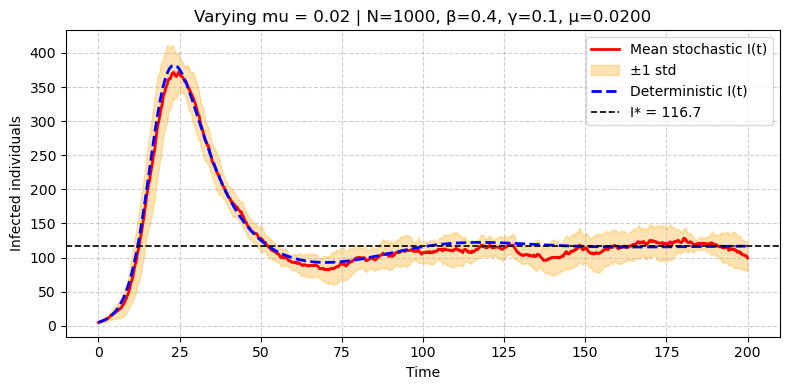

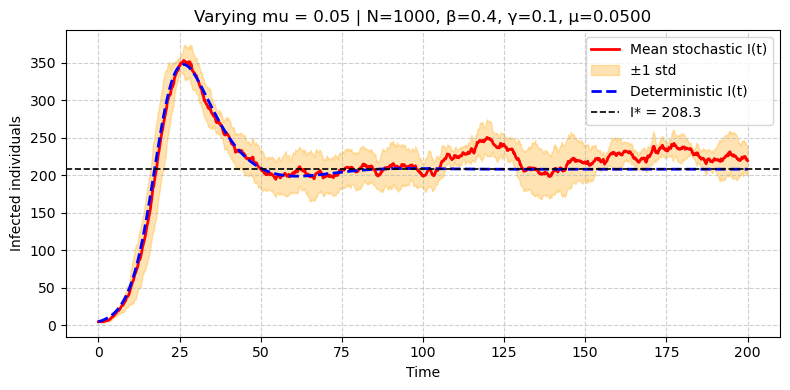

In [26]:
rng = np.random.default_rng(42)

I0 = 5
N = 1000
beta = 0.4
gamma = 0.1
mu = 0.05
t_max = 200
n_runs = 5

# varying N
N_values = [100, 500, 1000, 5000]
results_N, t_grid = stochastic_resonance_N(N_values, I0, beta, gamma, mu, t_max, n_runs, rng)
N_summary = plot_stochastic_resonance(results_N, t_grid, N, beta, gamma, mu, vary='N')

# varying beta
beta_values = [0.2, 0.4, 0.6, 0.8]
results_beta, t_grid = stochastic_resonance_beta(beta_values, I0, N, gamma, mu, t_max, n_runs, rng)
beta_summary = plot_stochastic_resonance(results_beta, t_grid, N, beta, gamma, mu, vary='beta')

# varying gamma
gamma_values = [0.05, 0.1, 0.3, 0.6]
results_gamma, t_grid = stochastic_resonance_gamma(gamma_values, I0, N, beta, mu, t_max, n_runs, rng)
gamma_summary = plot_stochastic_resonance(results_gamma, t_grid, N, beta, gamma, mu, vary='gamma')

# varying mu
mu_values = [0.005, 0.01, 0.02, 0.05]
results_mu, t_grid = stochastic_resonance_mu(mu_values, I0, N, beta, gamma, t_max, n_runs, rng)
mu_summary = plot_stochastic_resonance(results_mu, t_grid, N, beta, gamma, mu, vary='mu')

In [27]:
summary_data = {
    "N": N_summary,
    "beta": beta_summary,
    "gamma": gamma_summary,
    "mu": mu_summary
}

rows = []
for param_name, data in summary_data.items():
    for value, std_val, rel_transient in data:
        rows.append({
            "Parameter": param_name,
            "Value": value,
            "Normalized σ/mean": round(std_val, 3),
            "Rel. transient ∫|I−I*|": round(rel_transient, 3)
        })

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by=["Parameter", "Value"]).reset_index(drop=True)

print("\n📊 Summary of Stochastic Resonance Results\n")
print(summary_df.to_string(index=False))


📊 Summary of Stochastic Resonance Results

Parameter    Value  Normalized σ/mean  Rel. transient ∫|I−I*|
        N  100.000              0.383                   0.698
        N  500.000              0.163                   0.098
        N 1000.000              0.173                   0.042
        N 5000.000              0.142                   0.008
     beta    0.200              0.320                   0.073
     beta    0.400              0.145                   0.042
     beta    0.600              0.144                   0.042
     beta    0.800              0.144                   0.039
    gamma    0.050              0.130                   0.041
    gamma    0.100              0.163                   0.046
    gamma    0.300              1.649                   0.165
    gamma    0.600              4.659                   0.194
       mu    0.005              0.455                   0.327
       mu    0.010              0.215                   0.148
       mu    0.020        

## Problem 2: Spatial Models - Networks ##

In this question you are asked to develop a set of experiments to design and evaluate
vaccinationstrategiesusinganetworkmodel. UsingthepackageNDLib2 youshouldassess
the spread of a disease (SIR) across different types of model networks (Barabasi Albert,
Watts-Strogatz, Erdos-Reyni). Finally, you will run a simulated vaccination campaign
on a real contact network collected by sociopatterns (link). A modified version of this
dataset can be downloaded from Canvas, the network has been converted to a static
(non-temporal) form and some edges and nodes have been filtered out.

### Relevant graph statistics ###
1. Erdős–Rényi (ER) network: Degree distribution, average path-length and clustering coefficient
2. Barabási–Albert (BA) network: Degree distribution $P(k) = k^{-\gamma}$, highest degrees, average path length
3. Watts–Strogatz (WS) network:


In [76]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
import matplotlib.pyplot as plt

In [111]:
def model_configurator(model_type, beta, gamma, infected_initial):
    model = ep.SIRModel(model_type)

    # configuration of model parameters
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", infected_initial)

    # provide initial status 
    model.set_initial_status(config)

    # execution_number = number of runs
    # iteration_number = number of timestamps
    # infection_sets = node list with initial infected nodes
    # nprocesses = cpu parameters
    trends = multi_runs(model, execution_number=10, iteration_number=800, infection_sets=None, nprocesses=4)
    return model, trends

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd

# Parameters
N_values = np.linspace(100, 1000, 10, dtype=int)
k_values = np.arange(8, 40, 2, dtype=int)
rewiring_prob = 0.1

# Collect rows
rows = []

for N in N_values:
    for k in k_values:

        # model parameters to create equivalent models
        p = k / (N - 1)
        m = max(1, k // 2)

        # Build graphs
        graphs = [
            ("Erdős–Rényi", nx.erdos_renyi_graph(N, p)),
            ("Barabási–Albert", nx.barabasi_albert_graph(N, m)),
            ("Watts–Strogatz", nx.watts_strogatz_graph(N, k, rewiring_prob))
        ]

        # Append all rows
        for name, G in graphs:
            rows.append({
                "model": name,
                "N": N,
                "k": k,
                "edges": G.number_of_edges(),
                "mean_degree": np.mean([d for _, d in G.degree()]),
                "clustering": nx.average_clustering(G),
                "density": nx.density(G)
            })


df = pd.DataFrame(rows)

print(df)




               model     N   k  edges  mean_degree  clustering   density
0        Erdős–Rényi   100   8    436        8.720    0.098572  0.088081
1    Barabási–Albert   100   8    384        7.680    0.178076  0.077576
2     Watts–Strogatz   100   8    400        8.000    0.491454  0.080808
3        Erdős–Rényi   100  10    496        9.920    0.104487  0.100202
4    Barabási–Albert   100  10    475        9.500    0.192270  0.095960
..               ...   ...  ..    ...          ...         ...       ...
475  Barabási–Albert  1000  36  17676       35.352    0.089454  0.035387
476   Watts–Strogatz  1000  36  18000       36.000    0.540418  0.036036
477      Erdős–Rényi  1000  38  18910       37.820    0.037579  0.037858
478  Barabási–Albert  1000  38  18639       37.278    0.094074  0.037315
479   Watts–Strogatz  1000  38  19000       38.000    0.537440  0.038038

[480 rows x 7 columns]


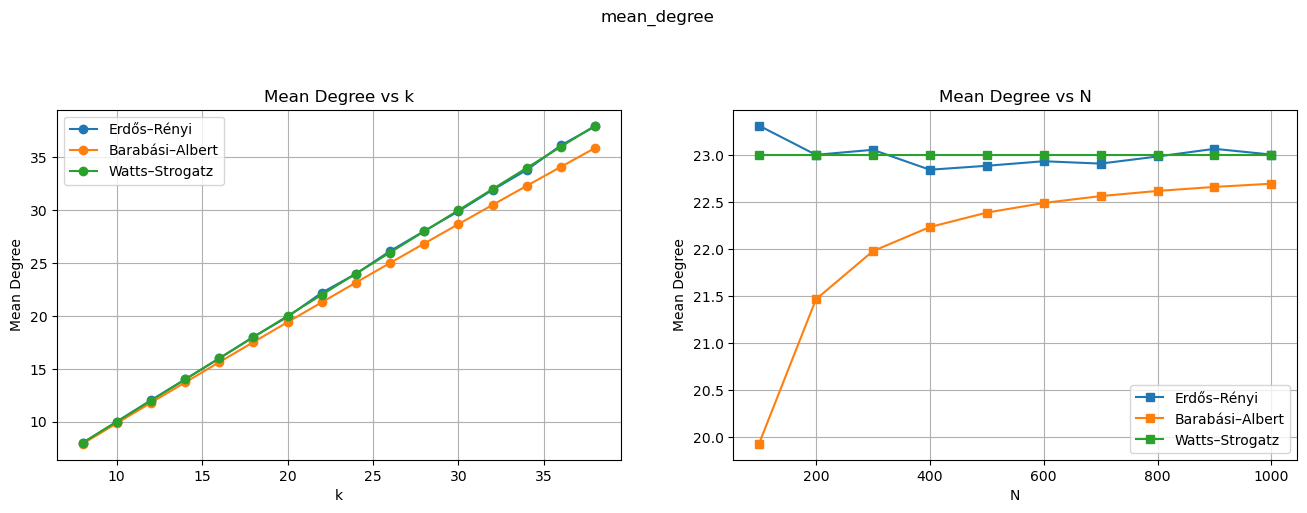

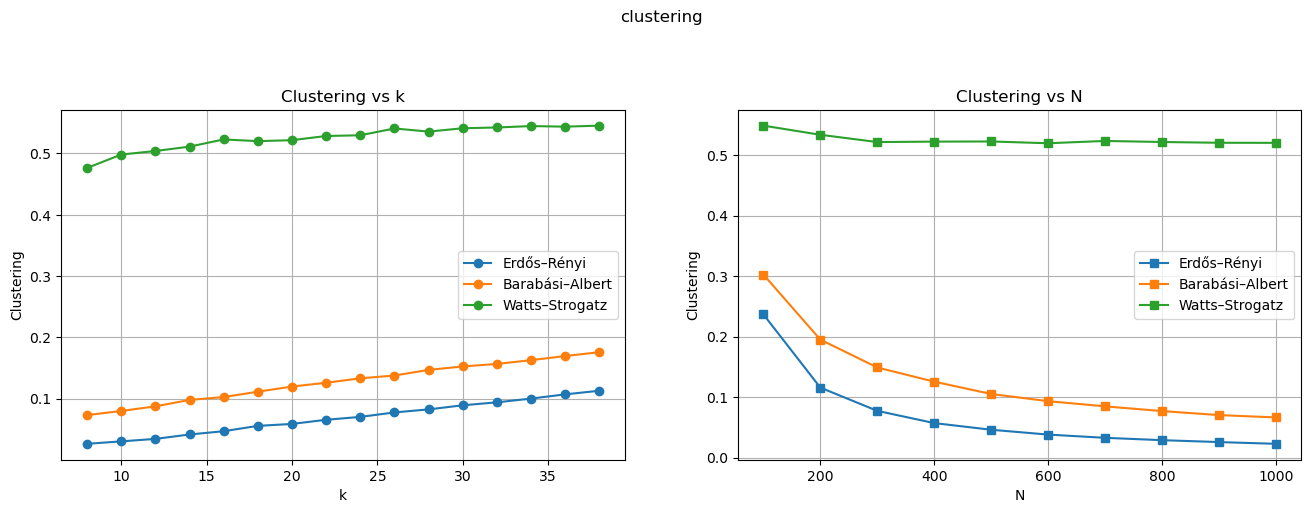

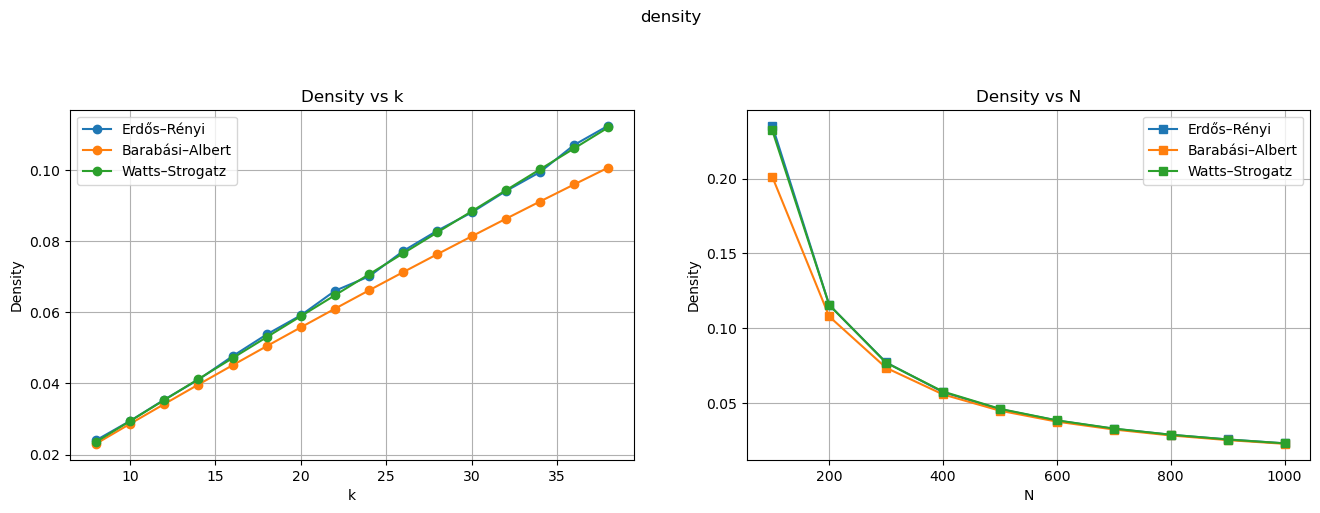

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Unique parameter values
models = df["model"].unique()
N_values = np.unique(df["N"])
k_values = np.unique(df["k"])

# List of statistics to visualize
statistics = ["mean_degree", "clustering", "density"]

# Iterate through each statistic
for stat in statistics:
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f"{stat}")

    # --- 1️⃣ stat vs k (averaged over N)
    plt.subplot(2, 2, 1)
    for model in models:
        y_vals = [np.mean(df[(df["model"] == model) & (df["k"] == k)][stat]) for k in k_values]
        plt.plot(k_values, y_vals, marker='o', label=model)
    plt.xlabel("k")
    plt.ylabel(stat.replace("_", " ").title())
    plt.title(f"{stat.replace('_', ' ').title()} vs k")
    plt.legend()
    plt.grid(True)

    # --- 2️⃣ stat vs N (averaged over k)
    plt.subplot(2, 2, 2)
    for model in models:
        y_vals = [np.mean(df[(df["model"] == model) & (df["N"] == N)][stat]) for N in N_values]
        plt.plot(N_values, y_vals, marker='s', label=model)
    plt.xlabel("N")
    plt.ylabel(stat.replace("_", " ").title())
    plt.title(f"{stat.replace('_', ' ').title()} vs N")
    plt.legend()
    plt.grid(True)

 


In [149]:
import numpy as np
def compute_network_statistics(G):
    # Degrees
    all_degrees = [d for _, d in G.degree()]
    mean_degree = float(np.mean(all_degrees))
    number_of_edges = G.number_of_edges()
    # Average clustering coefficient
    clustering = nx.average_clustering(G)
    
    # Degree centrality (average)
    degree_centrality = nx.degree_centrality(G)
    avg_degree_centrality = float(np.mean(list(degree_centrality.values())))
    
    # Betweenness centrality (average)
    betweenness_centrality = nx.betweenness_centrality(G)
    avg_betweenness_centrality = float(np.mean(list(betweenness_centrality.values())))
    
    # Network density
    density = nx.density(G)
    
    # Return only network-level (average) statistics
    return {
        'mean degree': mean_degree,
        'average clustering coefficient': clustering,
        'average betweenness centrality': avg_betweenness_centrality,
        'network density': density,
        'number of edges': number_of_edges
    }